Código proyecto semestral

Importamos los módulos necesarios

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

Definimos las condiciones inciales

In [2]:
T_0 = 289.65 #K Temperatura inicial de la simulación
T_suelo = 291.25 #K temperatura del suelo 

Ahora definimos los parametros físicos 

In [3]:
k = 0.13 # W / mK , conductividad térmica del maíz (del paper)
rho = 760 # Kg / m^3 , densidad del maíz (está como bulk density en el paper)
C_p = 1780 # kJ / Kg K , calor especifico del maíz (del paper)
q_tasa = 5.53 * (10**(-7)) # W , tasa de generación de calor 
Q_10 = 2 #Numero adimensional, indica que se duplica la tasa base de generacion de calor

def T_aire(t):
    temperatura= 293.15+7*np.cos((np.pi*(t-57600))/43200)
    return temperatura

epsilon = 0.28 #Epsilon de acero presentado en paper
sigma = 5.670374419 * (10**-8) #Constante de Stefan-Boltzmann en W/m^2K^4
h_s = 15 #Coeficiente de transferencia de calor por convección en W/m^2K 
v_z = 1/60000 # m / s Velocidad del aire en el silo ( Totalmente inventado, puse 1 por poner un numero, vamos a tener que cambiarlo)

Como tanto para el termino de generación como para el de perdida de calor existen factores no lineales, para la matriz de coeficientes A vamos a utilizar unicamente los coefcientes de los terminos de adveccción y difusión mientras que la generación y la perdida formaran parte del vector b.

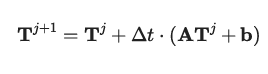

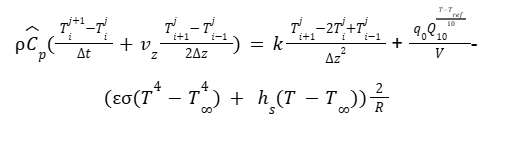

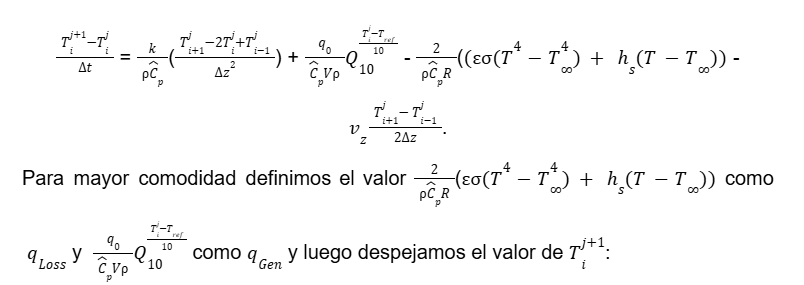
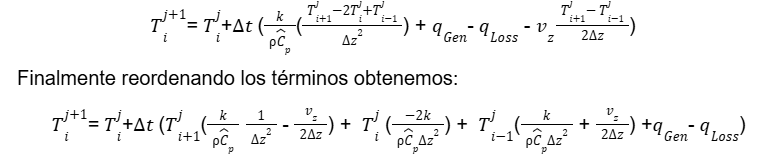

A continuación definimos los parámetros de tamaño para el primer silo a analizar

In [4]:
L_1 = 10 # m (largo del silo)
R_1 = 1 # m (radio del silo)
V_1 = np.pi * (R_1**2) * L_1 # m^3 (volumen del silo)

Ahora definimos los parámetros de la simulación

In [5]:
# Número de nodos en la dirección z 
n_z = 101   # Para todos los silos a analizar vamos a enfocarnos en 100 divisiones (101 nodos)

# Espaciamiento de tiempo 
dt = 600 # segundos, los intervalos de tiempo son de 10 minutos

z = np.linspace(0, L_1 , n_z + 1)
dz = L_1/(n_z-1)

# Condiciones iniciales
# Temperatura inicial a lo largo del silo
T = np.ones(n_z + 1) * T_0 

# Tiempo inicial y tiempo final
t_0 = 0 # segundos
t_f = 72 * 3600 # segundos, analizaremos 3 dias completos partiendo desde las 00:00 horas

Ahora generamos la matriz de coeficientes A y el vector b

In [6]:
A = np.zeros((n_z + 1, n_z + 1)) # Creamos la matriz A de ceros

for i in range(1, n_z):               # Llenamos la matriz A con los coeficientes obtenidos al discretizar
    A[i, i-1] = k/(rho * C_p * dz**2) + v_z/(2 * dz)
    A[i, i] = -2*k/(rho * C_p * dz**2)
    A[i, i+1] = k/(rho * C_p * dz**2) - v_z/(2 * dz)


Ahora anotamos las condciones de borde 


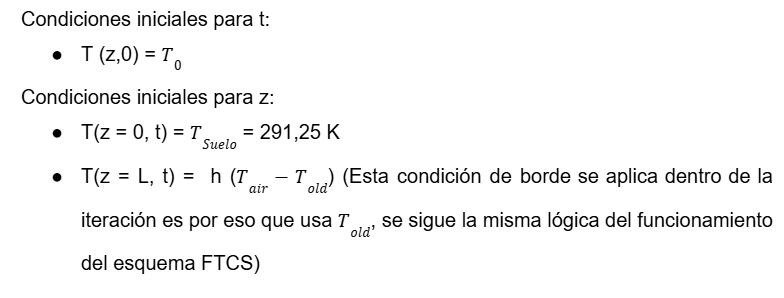

In [7]:
# Condición de frontera en z = 0 (suelo)
A[0,0] = 0       # Evitamos que la temperatura cambie en el nodo cercano al suelo producto de los coeficientes de la matriz A

# Condición de frontera en z = L (parte superior del silo)
A[-1, -1] = 0    # Evitamos que la temperatura cambie en el nodo superior del silo producto de los coeficientes de la matriz A


Ahora hacemos las iteraciones

In [8]:
write_interval = 600         # Vamos a guardar los datos cada 10 minutos (600 segundos)

t_vec = []  # Vector para almacenar los tiempos

T_old = np.copy(T) # Copia de la temperatura inicial

T_num = [] # Lista para almacenar las temperaturas en cada paso de tiempo

while t_0 < t_f:
    t_0 += dt
    b = (q_tasa /(V_1 * rho * C_p) * (Q_10**((T_old - T_aire(t_0))/10)) - 2/(rho * C_p* R_1) * (epsilon * sigma * (T_old**4 - T_aire(t_0)**4) + h_s * (T_old - T_aire(t_0))))   # Vector b que representa la generación y perdida de calor, va dentro de las iteraciones porque depende de la temperatura actual
    T_new = T_old + dt * (np.dot(A, T_old) + b)

    q_convección = h_s * (T_aire(t_0) - T_old[-1])  # Modelamos el efecto de la convección en la tapa superior del silo

    T_new[-1] += dt * (q_convección)/(rho * C_p * R_1)   # Le añadimos el efecto de la convección del aire en la tapa superior del silo funcionando como condición de borde en z = L

    T_new[0] = T_suelo  # Condición de frontera en z = 0 (suelo)

    T_old = np.copy(T_new) # Se guarda T_old como la temperatura actual para utilizarla en la siguiente iteración

    if t_0%write_interval < 0.9*dt:
        T_num.append(T_new)  # Almacenamos la temperatura en cada paso de tiempo
        t_vec.append(t_0)  # Almacenamos el tiempo correspondiente

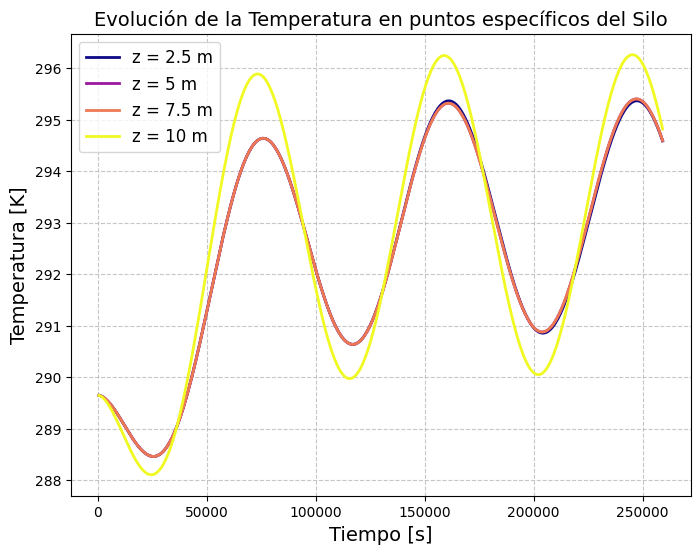

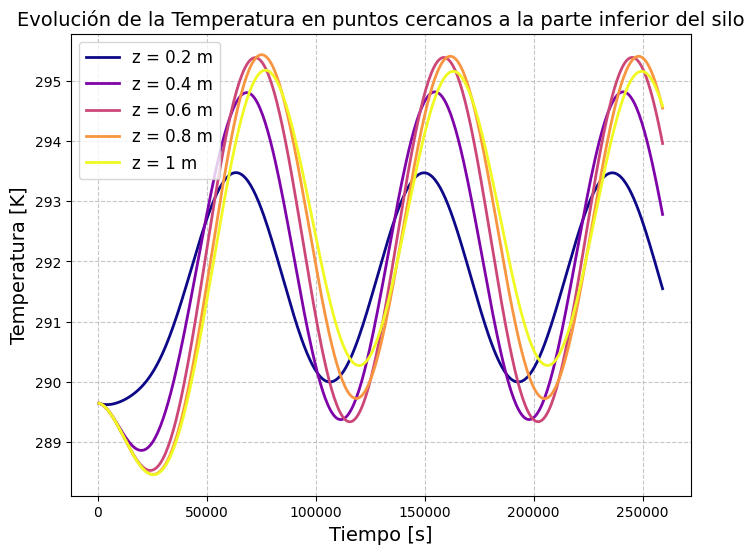

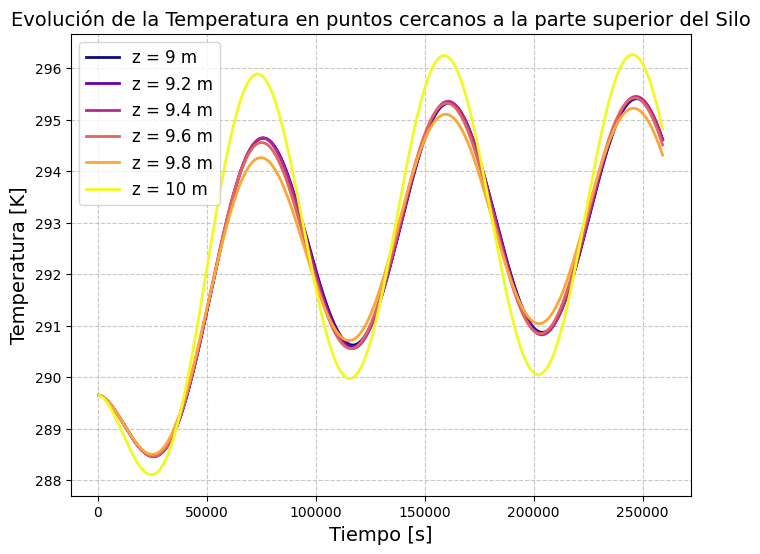

In [9]:
# Convertimos la lista de listas T_num a una matriz 
T_matriz = np.array(T_num)

######################## Primer gráfico ########################

# Primero vamos a graficar alturas a o largo de todo el silo
# Definimos los índices de las alturas a analizar
indices_interes_general = [25, 50, 75, 101]  # Corresponden a 2.5m, 5m, 7.5m, 10m
alturas_general = [2.5, 5, 7.5, 10]  # Eso lo usamos como etiquetas para graficar

fig, ax = plt.subplots(figsize=(8, 6)) #Creamos la figura en donde vamos a insertar el gráfico

# Usamos un mapa de colores para diferenciar las alturas
colores = cm.plasma(np.linspace(0, 1, len(indices_interes_general)))

for i, j in enumerate(indices_interes_general):

    # Graficamos la temperatura vs t_vec
    ax.plot(t_vec, T_matriz[:, j], color=colores[i], linewidth=2, label=f'z = {alturas_general[i]} m')

ax.set_xlabel('Tiempo [s]', fontsize=14) # Le asignamos nombre al eje X y unidad de medida
ax.set_ylabel('Temperatura [K]', fontsize=14) # Le asignamos nombre al eje Y y unidad de medida
ax.set_title('Evolución de la Temperatura en puntos específicos del Silo', fontsize=14) # Le asignamos título al gráfico
ax.grid(True, which='both', linestyle='--', alpha=0.7) # Hacemos que se vea la grilla para facilitar la identificación de valores en tiempos especificos
ax.legend(fontsize=12) # Hacemos que se vea la leyenda para identificar cada curva
plt.show()

######################## Segundo gráfico ########################

#Ahora vamos a graficar alturas cercanas a la parte inferior del silo
indices_inferior = [2, 4, 6, 8, 10]  # Corresponden a 0.2m, 0.4m, 0.6m, 0.8m, 1m
alturas_inferior = [0.2, 0.4, 0.6, 0.8, 1]  # Eso lo usamos como etiquetas para graficar

fig, ax = plt.subplots(figsize=(8, 6))

# Usamos un mapa de colores para diferenciar las alturas
colores = cm.plasma(np.linspace(0, 1, len(indices_inferior)))

for i, j in enumerate(indices_inferior):

    # Graficamos la temperatura vs t_vec
    ax.plot(t_vec, T_matriz[:, j], color=colores[i], linewidth=2, label=f'z = {alturas_inferior[i]} m')

ax.set_xlabel('Tiempo [s]', fontsize=14) # Le asignamos nombre al eje X y unidad de medida
ax.set_ylabel('Temperatura [K]', fontsize=14) # Le asignamos nombre al eje Y y unidad de medida
ax.set_title('Evolución de la Temperatura en puntos cercanos a la parte inferior del silo', fontsize=14) # Le asignamos título al gráfico
ax.grid(True, which='both', linestyle='--', alpha=0.7)  # Hacemos que se vea la grilla para facilitar la identificación de valores en tiempos especificos
ax.legend(fontsize=12)  # Hacemos que se vea la leyenda para identificar cada curva
plt.show()

######################## Tercer gráfico ########################

#Ahora vamos a graficar alturas cercanas a la parte superior del silo
indices_superior = [90, 92, 94, 96, 98, 101]  # Corresponden a 9m, 9.2m, 9.4m, 9.6m, 9.8m, 10m
alturas_superior = [9, 9.2, 9.4, 9.6, 9.8, 10]  # Eso lo usamos como etiquetas para graficar

fig, ax = plt.subplots(figsize=(8, 6))

# Usamos un mapa de colores para diferenciar las alturas
colores = cm.plasma(np.linspace(0, 1, len(indices_superior)))

for i, j in enumerate(indices_superior):

    # Graficamos la temperatura vs t_vec
    ax.plot(t_vec, T_matriz[:, j], color=colores[i], linewidth=2, label=f'z = {alturas_superior[i]} m')

ax.set_xlabel('Tiempo [s]', fontsize=14) # Le asignamos nombre al eje X y unidad de medida
ax.set_ylabel('Temperatura [K]', fontsize=14) # Le asignamos nombre al eje Y y unidad de medida
ax.set_title('Evolución de la Temperatura en puntos cercanos a la parte superior del Silo', fontsize=14) # Le asignamos título al gráfico
ax.grid(True, which='both', linestyle='--', alpha=0.7)  # Hacemos que se vea la grilla para facilitar la identificación de valores en tiempos especificos
ax.legend(fontsize=12)  # Hacemos que se vea la leyenda para identificar cada curva
plt.show()

Ahora realizamos el mismo procedimiento para un segundo silo

In [10]:
L_2 = 10 #m (largo del silo)
R_2 = 2 #m (radio del silo)
V_2 = np.pi * (R_2**2) * L_2 #m^3 (volumen del silo)

In [11]:
# Número de nodos en la dirección z
n_z = 101   

# Espaciamiento de tiempo 
dt = 600 # segundos, intervalos de 10 minutos

z = np.linspace(0, L_2 , n_z + 1)
dz = L_2/(n_z-1)

# Condiciones iniciales
# Temperatura inicial a lo largo del silo
T = np.ones(n_z + 1) * T_0 

# Tiempo inicial y tiempo final
t_0 = 0 # segundos
t_f = 72 * 3600 # segundos, analizaremos 3 dias completos partiendo desde las 00:00 horas

In [12]:
A = np.zeros((n_z + 1, n_z + 1))    # Creamos la matriz A de ceros

for i in range(1, n_z):               # Llenamos la matriz A con los coeficientes obtenidos al discretizar
    A[i, i-1] = k/(rho * C_p * dz**2) + v_z/(2 * dz)
    A[i, i] = -2*k/(rho * C_p * dz**2)
    A[i, i+1] = k/(rho * C_p * dz**2) - v_z/(2 * dz)

# Condición de frontera en z = 0 (suelo)
A[0,0] = 0       # Evitamos que la temperatura cambie en el nodo cercano al suelo producto de los coeficientes de la matriz A

# Condición de frontera en z = L (parte superior del silo)
A[-1, -1] = 0    # Evitamos que la temperatura cambie en el nodo superior del silo producto de los coeficientes de la matriz A

In [13]:
write_interval = 600

t_vec = []  # Vector para almacenar los tiempos

T_old = np.copy(T) # Copia de la temperatura inicial

T_num = [] # Lista para almacenar las temperaturas en cada paso de tiempo

while t_0 < t_f:
    t_0 += dt
    b = (q_tasa/(V_2 * rho * C_p) * (Q_10**((T_old - T_aire(t_0))/10)) - 2/(rho * C_p* R_2) * (epsilon * sigma * (T_old**4 - T_aire(t_0)**4) + h_s * (T_old - T_aire(t_0))))
    T_new = T_old + dt * (np.dot(A, T_old) + b)

    q_convección = h_s * (T_aire(t_0) - T_old[-1])  # Modelamos el efecto de la convección en la tapa superior del silo
    T_new[-1] += dt * (q_convección)/(rho * C_p * R_2)  # Le añadimos el efecto de la convección del aire en la tapa superior del silo funcionando como condición de borde en z = L

    T_new[0] = T_suelo  # Condición de frontera en z = 0 (suelo)

    T_old = np.copy(T_new)

    

    if t_0%write_interval < 0.9*dt:
        T_num.append(T_new)  # Almacenamos la temperatura en cada paso de tiempo
        t_vec.append(t_0)  # Almacenamos el tiempo correspondiente


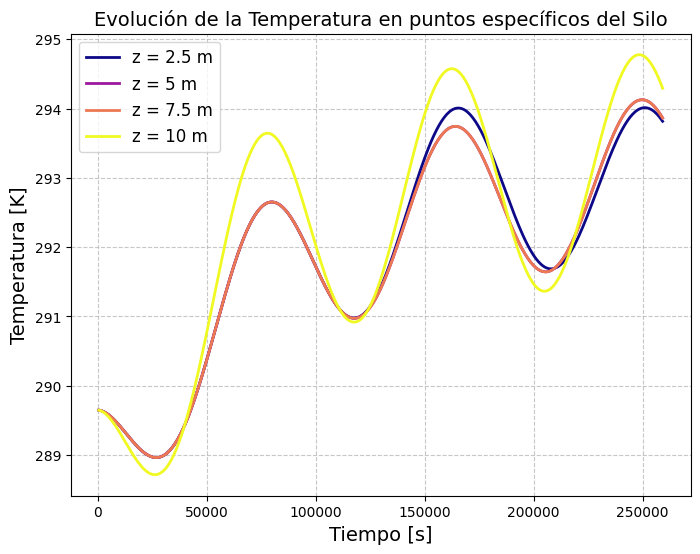

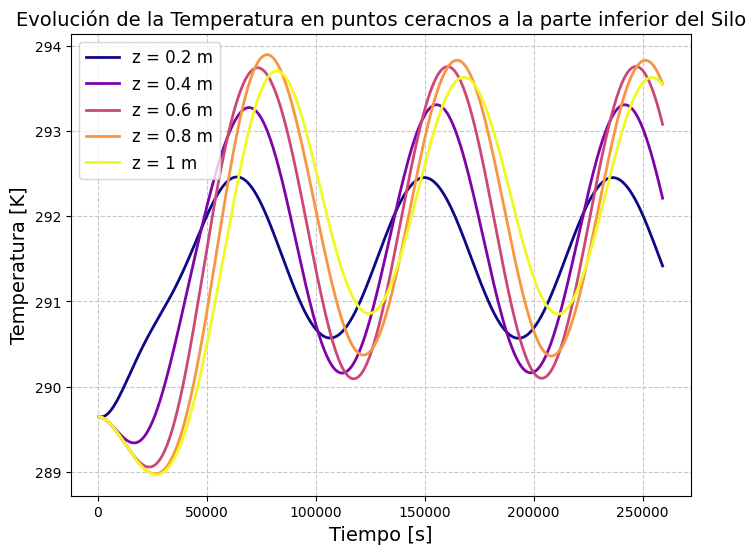

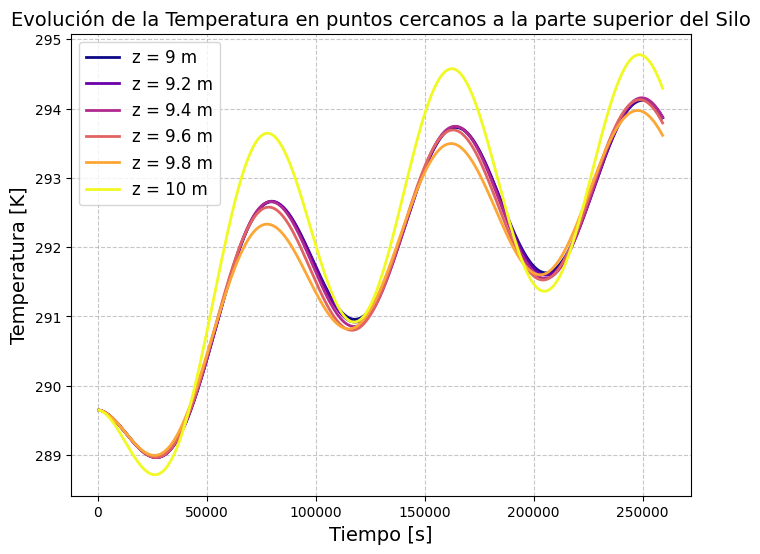

In [14]:
# Convertimos la lista de listas T_num a una matriz 
T_matriz = np.array(T_num)

######################## Primer gráfico ########################

# Primero vamos a graficar alturas a o largo de todo el silo
# Definimos los índices de las alturas a analizar
indices_interes_general = [25, 50, 75, 101]  # Corresponden a 2.5m, 5m, 7.5m, 10m
alturas_general = [2.5, 5, 7.5, 10]  # Eso lo usamos como etiquetas para graficar

fig, ax = plt.subplots(figsize=(8, 6)) #Creamos la figura en donde vamos a insertar el gráfico

# Usamos un mapa de colores para diferenciar las alturas
colores = cm.plasma(np.linspace(0, 1, len(indices_interes_general)))

for i, j in enumerate(indices_interes_general):
    
    # Graficamos la temperatura vs t_vec
    ax.plot(t_vec, T_matriz[:, j], color=colores[i], linewidth=2, label=f'z = {alturas_general[i]} m')

ax.set_xlabel('Tiempo [s]', fontsize=14) # Le asignamos nombre al eje X y unidad de medida
ax.set_ylabel('Temperatura [K]', fontsize=14) # Le asignamos nombre al eje Y y unidad de medida
ax.set_title('Evolución de la Temperatura en puntos específicos del Silo', fontsize=14) # Le asignamos título al gráfico
ax.grid(True, which='both', linestyle='--', alpha=0.7) # Hacemos que se vea la grilla para facilitar la identificación de valores en tiempos especificos
ax.legend(fontsize=12) # Hacemos que se vea la leyenda para identificar cada curva
plt.show()

######################## Segundo gráfico ########################

#Ahora vamos a graficar alturas cercanas a la parte inferior del silo
indices_inferior = [2, 4, 6, 8, 10]  # Corresponden a 0.2m, 0.4m, 0.6m, 0.8m, 1m
alturas_inferior = [0.2, 0.4, 0.6, 0.8, 1]  # Eso lo usamos como etiquetas para graficar

fig, ax = plt.subplots(figsize=(8, 6))

# Usamos un mapa de colores para diferenciar las alturas
colores = cm.plasma(np.linspace(0, 1, len(indices_inferior)))

for i, j in enumerate(indices_inferior):
    
    # Graficamos la temperatura vs t_vec
    ax.plot(t_vec, T_matriz[:, j], color=colores[i], linewidth=2, label=f'z = {alturas_inferior[i]} m')

ax.set_xlabel('Tiempo [s]', fontsize=14) # Le asignamos nombre al eje X y unidad de medida
ax.set_ylabel('Temperatura [K]', fontsize=14) # Le asignamos nombre al eje Y y unidad de medida
ax.set_title('Evolución de la Temperatura en puntos ceracnos a la parte inferior del Silo', fontsize=14) # Le asignamos título al gráfico
ax.grid(True, which='both', linestyle='--', alpha=0.7) # Hacemos que se vea la grilla para facilitar la identificación de valores en tiempos especificos
ax.legend(fontsize=12) # Hacemos que se vea la leyenda para identificar cada curva
plt.show()

######################## Tercer gráfico ########################

#Ahora vamos a graficar alturas cercanas a la parte superior del silo
indices_superior = [90, 92, 94, 96, 98, 101]  # Corresponden a 9m, 9.2m, 9.4m, 9.6m, 9.8m, 10m
alturas_superior = [9, 9.2, 9.4, 9.6, 9.8, 10]  # Eso lo usamos como etiquetas para graficar

fig, ax = plt.subplots(figsize=(8, 6))

# Usamos un mapa de colores para diferenciar las alturas
colores = cm.plasma(np.linspace(0, 1, len(indices_superior)))

for i, j in enumerate(indices_superior):
    
    # Graficamos la temperatura vs t_vec
    ax.plot(t_vec, T_matriz[:, j], color=colores[i], linewidth=2, label=f'z = {alturas_superior[i]} m')

ax.set_xlabel('Tiempo [s]', fontsize=14) # Le asignamos nombre al eje X y unidad de medida
ax.set_ylabel('Temperatura [K]', fontsize=14) # Le asignamos nombre al eje Y y unidad de medida
ax.set_title('Evolución de la Temperatura en puntos cercanos a la parte superior del Silo', fontsize=14) # Le asignamos título al gráfico
ax.grid(True, which='both', linestyle='--', alpha=0.7) # Hacemos que se vea la grilla para facilitar la identificación de valores en tiempos especificos
ax.legend(fontsize=12) # Hacemos que se vea la leyenda para identificar cada curva
plt.show()

Repetimos el procedimiento para el tercer silo

In [15]:
L_3 = 5 #m (largo del silo)
R_3 = 1 #m (radio del silo)
V_3 = np.pi * (R_3**2) * L_3 #m^3 (volumen del silo)

In [16]:
# Número de nodos en la dirección z 
n_z = 101  

# Espaciamiento de tiempo (hay que pensar bien cuanto tiempo queremos simular, por mientras voy a utilizar 24 horas con pasos de 10 minutos)
dt = 600 # segundos

z = np.linspace(0, L_3 , n_z + 1)
dz = L_3/(n_z-1)

# Condiciones iniciales
# Temperatura inicial a lo largo del silo
T = np.ones(n_z + 1) * T_0 

# Tiempo inicial y tiempo final
t_0 = 0 # segundos
t_f = 72 * 3600 # segundos, analizaremos 3 dias completos partiendo desde las 00:00 horas

In [17]:
A = np.zeros((n_z + 1, n_z + 1))

for i in range(1, n_z):
    A[i, i-1] = k/(rho * C_p * dz**2) + v_z/(2 * dz)
    A[i, i] = -2*k/(rho * C_p * dz**2)
    A[i, i+1] = k/(rho * C_p * dz**2) - v_z/(2 * dz)
#Condición de frontera en z = 0 (suelo)
A[0, 0] = 0     # Evitamos que la temperatura cambie en el nodo cercano al suelo producto de los coeficientes de la matriz A
#Condición de frontera en z = L (parte superior del silo)
A[-1, -1] = 0   # Evitamos que la temperatura cambie en el nodo superior del silo producto de los coeficientes de la matriz A

In [18]:
write_interval = 600

t_vec = []  # Vector para almacenar los tiempos

T_old = np.copy(T) # Copia de la temperatura inicial

T_num = [] # Lista para almacenar las temperaturas en cada paso de tiempo

while t_0 < t_f:
    t_0 += dt
    b = (q_tasa/(V_3 * rho * C_p) * (Q_10**((T_old - T_aire(t_0))/10)) - 2/(rho * C_p* R_3) * (epsilon * sigma * (T_old**4 - T_aire(t_0)**4) + h_s * (T_old - T_aire(t_0))))
    T_new = T_old + dt * (np.dot(A, T_old) + b)

    q_convección = h_s * (T_aire(t_0) - T_old[-1]) # Modelamos el efecto de la convección en la tapa superior del silo
    T_new[-1] += dt * (q_convección)/(rho * C_p * R_3)  # Le añadimos el efecto de la convección del aire en la tapa superior del silo funcionando como condición de borde en z = L
    
    T_new[0] = T_suelo  # Condición de frontera en z = 0 (suelo)

    T_old = np.copy(T_new)

    

    if t_0%write_interval < 0.9*dt:
        T_num.append(T_new)  # Almacenar la temperatura en cada paso de tiempo
        t_vec.append(t_0)  # Almacenar el tiempo correspondiente

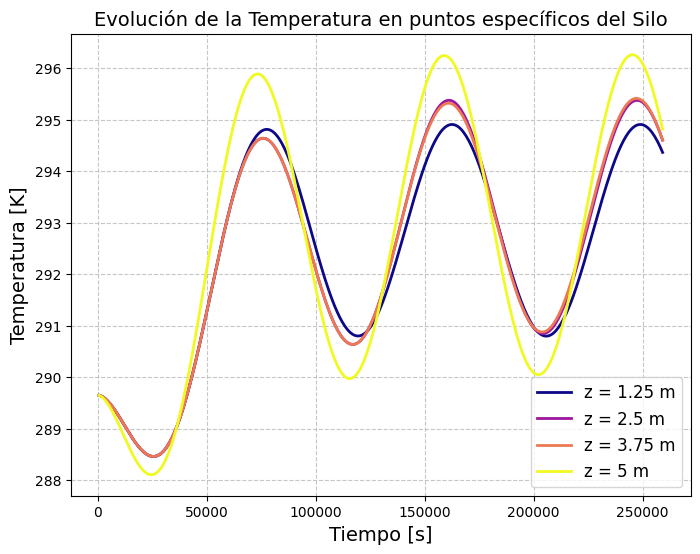

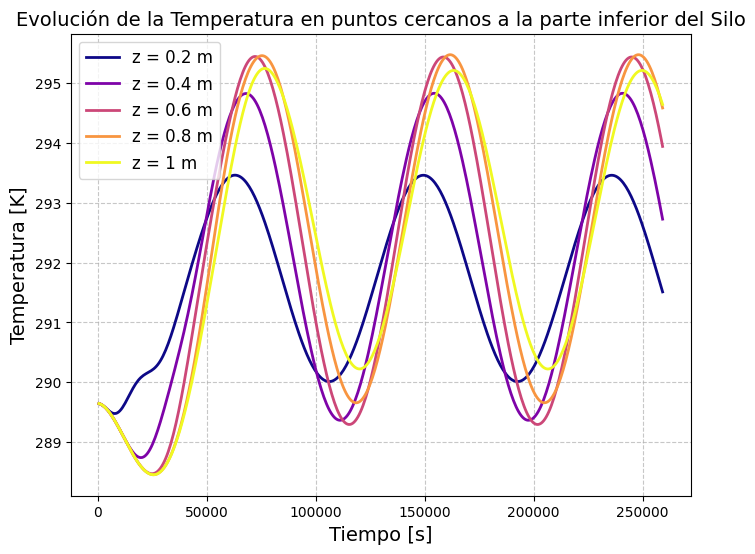

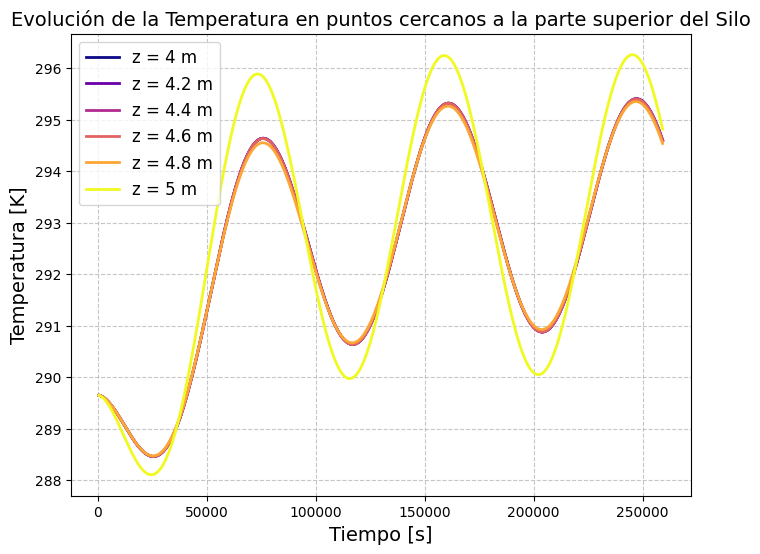

In [19]:
# Convertimos la lista de listas T_num a una matriz 
T_matriz = np.array(T_num)

######################## Primer gráfico ########################

# Primero vamos a graficar alturas a o largo de todo el silo
# Definimos los índices de las alturas a analizar
indices_interes_general = [25, 50, 75, 101]  # Corresponden a 1.25m, 2.5m, 3.75m, 5m
alturas_general = [1.25, 2.5, 3.75, 5]  # Eso lo usamos como etiquetas para graficar

fig, ax = plt.subplots(figsize=(8, 6)) #Creamos la figura en donde vamos a insertar el gráfico

# Usamos un mapa de colores para diferenciar las alturas
colores = cm.plasma(np.linspace(0, 1, len(indices_interes_general)))

for i, j in enumerate(indices_interes_general):

    # Graficamos la temperatura vs t_vec
    ax.plot(t_vec, T_matriz[:, j], color=colores[i], linewidth=2, label=f'z = {alturas_general[i]} m')

ax.set_xlabel('Tiempo [s]', fontsize=14) # Le asignamos nombre al eje X y unidad de medida
ax.set_ylabel('Temperatura [K]', fontsize=14) # Le asignamos nombre al eje Y y unidad de medida
ax.set_title('Evolución de la Temperatura en puntos específicos del Silo', fontsize=14) # Le asignamos título al gráfico
ax.grid(True, which='both', linestyle='--', alpha=0.7) # Hacemos que se vea la grilla para facilitar la identificación de valores en tiempos especificos
ax.legend(fontsize=12) # Hacemos que se vea la leyenda para identificar cada curva
plt.show()

######################## Segundo gráfico ########################

#Ahora vamos a graficar alturas cercanas a la parte inferior del silo
indices_inferior = [4, 8, 12, 16, 20]  # Corresponden a 0.2m, 0.4m, 0.6m, 0.8m, 1m
alturas_inferior = [0.2, 0.4, 0.6, 0.8, 1]  # Eso lo usamos como etiquetas para graficar

fig, ax = plt.subplots(figsize=(8, 6)) #Creamos la figura en donde vamos a insertar el gráfico

# Usamos un mapa de colores para diferenciar las alturas
colores = cm.plasma(np.linspace(0, 1, len(indices_inferior)))

for i, j in enumerate(indices_inferior):

    # Graficamos la temperatura vs t_vec
    ax.plot(t_vec, T_matriz[:, j], color=colores[i], linewidth=2, label=f'z = {alturas_inferior[i]} m')

ax.set_xlabel('Tiempo [s]', fontsize=14) # Le asignamos nombre al eje X y unidad de medida
ax.set_ylabel('Temperatura [K]', fontsize=14) # Le asignamos nombre al eje Y y unidad de medida
ax.set_title('Evolución de la Temperatura en puntos cercanos a la parte inferior del Silo', fontsize=14) # Le asignamos título al gráfico
ax.grid(True, which='both', linestyle='--', alpha=0.7) # Hacemos que se vea la grilla para facilitar la identificación de valores en tiempos especificos
ax.legend(fontsize=12) # Hacemos que se vea la leyenda para identificar cada curva
plt.show()

######################## Tercer gráfico ########################

#Ahora vamos a graficar alturas cercanas a la parte superior del silo
indices_superior = [80, 84, 88, 92, 96, 101]  # Corresponden a 4m, 4.2m, 4.4m, 4.6m, 4.8m, 10m
alturas_superior = [4, 4.2, 4.4, 4.6, 4.8, 5]  # Eso lo usamos como etiquetas para graficar

fig, ax = plt.subplots(figsize=(8, 6)) #Creamos la figura en donde vamos a insertar el gráfico

# Usamos un mapa de colores para diferenciar las alturas
colores = cm.plasma(np.linspace(0, 1, len(indices_superior)))

for i, j in enumerate(indices_superior):
    
    # Graficamos la temperatura vs t_vec
    ax.plot(t_vec, T_matriz[:, j], color=colores[i], linewidth=2, label=f'z = {alturas_superior[i]} m')

ax.set_xlabel('Tiempo [s]', fontsize=14) # Le asignamos nombre al eje X y unidad de medida
ax.set_ylabel('Temperatura [K]', fontsize=14) # Le asignamos nombre al eje Y y unidad de medida
ax.set_title('Evolución de la Temperatura en puntos cercanos a la parte superior del Silo', fontsize=14) # Le asignamos título al gráfico
ax.grid(True, which='both', linestyle='--', alpha=0.7) # Hacemos que se vea la grilla para facilitar la identificación de valores en tiempos especificos
ax.legend(fontsize=12) # Hacemos que se vea la leyenda para identificar cada curva
plt.show()